# Functionality

Simulated data for validation the usage of ciCOH

* using Samplings from normal distributions for no connections

* using sinusoidal signals for connections

* using a linear mix equation for volume conduction

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import random
import pandas as pd
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## Preparation

### exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder, correparentfolder = code_corresfolder(os.getcwd(), nb_name)

### Global parameters

In [6]:
ntemp, ntrials = 500, 93

# repeat ntimes
ntimes = 1000

### Input setup

### Save setup

In [7]:
savefolder = corresfolder

##  Simulated Data with Normal Distribution (no connection)

In [8]:
mu, sigma = 0, 1

### A trial Example

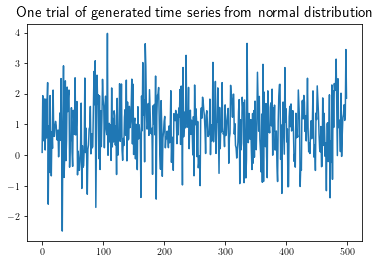

In [65]:
import matplotlib.pyplot as plt
from numpy.random import normal

# generated s signals: 
sig = normal(mu, sigma, (ntemp,))
    
# plot
plt.rc('text', usetex=True)

plt.plot(sig)

title = "One trial of generated time series from normal distribution"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "normal_oneTrialExample.png"))
             
sig_normal = sig

### generate time series 

In [66]:
sigs1_normal, sigs2_normal = normal(mu, sigma, (ntimes, ntrials, ntemp)), normal(mu, sigma, (ntimes, ntrials, ntemp)) 

### Calc ciCOH

In [ ]:
import numpy as np
from numpy.random import normal

sigs1, sigs2 = sigs1_normal, sigs2_normal

ciCOHs = []
for timei in range(ntimes):

    sig1, sig2 = sigs1[timei, :, :], sigs2[timei, :, :]
    
    # calculate ciCOH
    ciCOH = np.mean(ciCoherence_acrosstrials(sig1, sig2))
    ciCOHs.append(ciCOH)
    
    del ciCOH, sig1, sig2 
    
ciCOHs_normal = ciCOHs
del ciCOHs

### plot ciCOH

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

ciCOHs = ciCOHs_normal

plt.rc('text', usetex=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(ciCOHs)

# Plot the histogram.
plt.hist(ciCOHs, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


# plot the 2*std lines
plt.plot([mu + 2 * std, mu + 2 * std], np.array(plt.ylim())/2, 'b--', 
         [mu - 2 * std, mu - 2 * std], np.array(plt.ylim())/2, 'b--')

# plot the 3*std lines
plt.plot([mu + 3 * std, mu + 3 * std], np.array(plt.ylim())/2, 'k--', 
         [mu - 3 * std, mu - 3 * std], np.array(plt.ylim())/2, 'k--')


eq1 = r"\begin{eqnarray*}" + \
      r"\mu = " + str(np.around(mu, decimals=2)) + "\\"\
      r"\std = " + str(np.around(std, decimals=4)) + "\\"\
      r"\95 \%= " + str(np.around(mu + 2*std, decimals=4)) + "\\"\
      r"\99 \%= " + str(np.around(mu + 3*std, decimals=4)) +\
      r"\end{eqnarray*}"

plt.text(0.008, 90, eq1, {'fontsize': 12}, va="top", ha="left")

title = "Probability distribution fit of ciCOH data"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "normal_ciCOHpdf.png"))

del ciCOHs

## Simulated Data with Sinusoidal Distribution (with Connection)

In [11]:
Desired_SNR_dB = 20

f = 30

t = np.linspace(0, 0.5, ntemp)

### A trial example

In [12]:
import numpy as np

def GaussianNoise_SNR(signal, Desired_SNR_dB):
    """
        add desired SNR (dB) gaussian noise to signal
        SNR(dB) = 10 * log10(power_signal/power_noise)

        @ parameter:
            signal: (n_times,)
            Desired_SNR_dB: desired SNR in dB
        
        @ return 
            signal_noisy: (n_times,)
    """
    
    n_times = signal.shape[0]
    noise = np.random.normal(loc=0.0, scale=1.0, size=(n_times,))

    power_signal = np.dot(abs(signal), abs(signal))/n_times
    power_noise = np.dot(abs(noise), abs(noise))/n_times 

    k = (power_signal * pow(10,(-Desired_SNR_dB/10)))/power_noise # scale factor
    noise_new = np.sqrt(k) * noise

    signal_noisy = signal + noise_new

    return signal_noisy

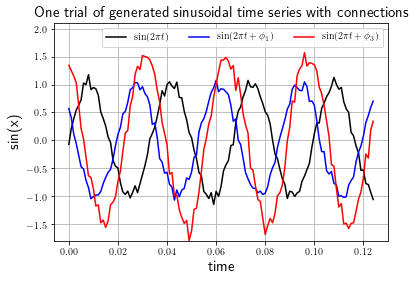

In [90]:
import matplotlib.pylab as plt
from numpy.random import normal
plt.rc('text', usetex=True)

phi1 = normal(loc=np.pi, scale=1.0)
phi2 = normal(loc=np.pi/2, scale=1.0)

s1 = np.sin(2 * np.pi * f* t)
s2 = np.sin(2 * np.pi * f * t + phi1)
s3 = 1.5 * np.sin(2 * np.pi * f* t + phi2)


# add normal distribution noise
s1 = GaussianNoise_SNR(s1, Desired_SNR_dB = Desired_SNR_dB)
s2 = GaussianNoise_SNR(s2, Desired_SNR_dB = Desired_SNR_dB)
s3 = GaussianNoise_SNR(s3, Desired_SNR_dB = Desired_SNR_dB)

npoints = 125
fig, ax = plt.subplots()

plt.plot(t[0:npoints], s1[0:npoints], 'k', t[0:npoints], s2[0:npoints], 'b',t[0:npoints], s3[0:npoints], 'r')


plt.xlabel('time', size=15)
plt.ylabel('sin(x)', size=15)
plt.axis('tight')
plt.ylim(-1.8, 2.1)

ax.grid()

# legend
eq1 = r"\begin{eqnarray*}" + r"\sin(2\pi t)" +  r"\end{eqnarray*}"
eq2 = r"\begin{eqnarray*}" + r"\sin(2\pi t + \phi_1)" +  r"\end{eqnarray*}"
eq3 = r"\begin{eqnarray*}" + r"\sin(2\pi t + \phi_3)" +  r"\end{eqnarray*}"
plt.legend((eq1, eq2, eq3), ncol = 3, loc = 1)


title = "One trial of generated sinusoidal time series with connections"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "sin_TimeSeries_Exampe.png"))

s1_1trial_sin, s2_1trial_sin, s3_1trial_sin = s1, s2, s3

### generate time series

In [36]:
# generated s1, s2 and s3 signals: ntimes * ntrials * ntemp
sigs1, sigs2 = np.empty(shape=(0, ntrials, ntemp)), np.empty(shape=(0, ntrials, ntemp))
sigs3 = np.empty(shape=(0, ntrials, ntemp))
for timei in range(ntimes):
    
    if timei % 20 ==0:
        print("timei = " + str(timei) + "/" + str(ntimes))
    
    # generated s1, s2 and s3 signals: ntrials * ntemp
    sig1, sig2, sig3 = np.empty(shape=[0,ntemp]), np.empty(shape=[0,ntemp]), np.empty(shape=[0,ntemp])
    phi1 = normal(loc=np.pi, scale=1.0)
    phi2 = normal(loc=np.pi/2, scale=1.0)
    for triali in range(ntrials):
        
        s1 = np.sin(2 * np.pi * f * t)
        s2 = np.sin(2 * np.pi * f * t + phi1)
        s3 = 1.5 * np.sin(2 * np.pi * f * t + phi2)

        # add normal distribution noise
        s1 = GaussianNoise_SNR(s1, Desired_SNR_dB = Desired_SNR_dB)
        s2 = GaussianNoise_SNR(s2, Desired_SNR_dB = Desired_SNR_dB)
        s3 = GaussianNoise_SNR(s3, Desired_SNR_dB = Desired_SNR_dB)

        # append the time serie of the new trial
        sig1 = np.append(sig1, np.expand_dims(s1, axis = 0), axis=0)
        sig2 = np.append(sig2, np.expand_dims(s2, axis = 0), axis=0)
        sig3 = np.append(sig3, np.expand_dims(s3, axis = 0), axis=0)
        
        del s1, s2, s3
        
    # append the time serie of the new trial
    sigs1 = np.append(sigs1, np.expand_dims(sig1, axis = 0), axis=0)
    sigs2 = np.append(sigs2, np.expand_dims(sig2, axis = 0), axis=0)
    sigs3 = np.append(sigs3, np.expand_dims(sig3, axis = 0), axis=0)
    
    del sig1, sig2, sig3
    
sigs1_sin, sigs2_sin, sigs3_sin = sigs1, sigs2, sigs3

del sigs1, sigs2, sigs3

timei = 0/1000
timei = 5/1000
timei = 10/1000
timei = 15/1000
timei = 20/1000
timei = 25/1000
timei = 30/1000
timei = 35/1000
timei = 40/1000
timei = 45/1000
timei = 50/1000
timei = 55/1000
timei = 60/1000
timei = 65/1000
timei = 70/1000
timei = 75/1000
timei = 80/1000
timei = 85/1000
timei = 90/1000
timei = 95/1000
timei = 100/1000
timei = 105/1000
timei = 110/1000
timei = 115/1000
timei = 120/1000
timei = 125/1000
timei = 130/1000
timei = 135/1000
timei = 140/1000
timei = 145/1000
timei = 150/1000
timei = 155/1000
timei = 160/1000
timei = 165/1000
timei = 170/1000
timei = 175/1000
timei = 180/1000
timei = 185/1000
timei = 190/1000
timei = 195/1000
timei = 200/1000
timei = 205/1000
timei = 210/1000
timei = 215/1000
timei = 220/1000
timei = 225/1000
timei = 230/1000
timei = 235/1000
timei = 240/1000
timei = 245/1000
timei = 250/1000
timei = 255/1000
timei = 260/1000
timei = 265/1000
timei = 270/1000
timei = 275/1000
timei = 280/1000
timei = 285/1000
timei = 290/1000
timei = 295/1000
ti

### Calc ciCOH 

In [38]:
import matplotlib.pylab as plt
from numpy.random import normal

sigs1, sigs2, sigs3 = sigs1_sin, sigs2_sin, sigs3_sin

ciCOHs_12, ciCOHs_13 = [], []
for timei in range(ntimes):
    
    if timei % 100 ==0:
        print("timei = " + str(timei) + "/" + str(ntimes))
    
    sig1, sig2, sig3 = sigs1[timei, :, :], sigs2[timei, :, :], sigs3[timei, :, :]
        
    # calculate ciCOH
    ciCOH_12 = np.mean(ciCoherence_acrosstrials(sig1, sig2))
    ciCOH_13 = np.mean(ciCoherence_acrosstrials(sig1, sig3))
    ciCOHs_12.append(ciCOH_12)
    ciCOHs_13.append(ciCOH_13)
        
    
    del sig1, sig2, sig3, ciCOH_12, ciCOH_13
    
ciCOHs_sin12, ciCOHs_sin13 = ciCOHs_12, ciCOHs_13
del ciCOHs_12, ciCOHs_13, sigs1, sigs2, sigs3

timei = 0/1000
timei = 20/1000
timei = 40/1000
timei = 60/1000
timei = 80/1000
timei = 100/1000
timei = 120/1000
timei = 140/1000
timei = 160/1000
timei = 180/1000
timei = 200/1000
timei = 220/1000
timei = 240/1000
timei = 260/1000
timei = 280/1000
timei = 300/1000
timei = 320/1000
timei = 340/1000
timei = 360/1000
timei = 380/1000
timei = 400/1000
timei = 420/1000
timei = 440/1000
timei = 460/1000
timei = 480/1000
timei = 500/1000
timei = 520/1000
timei = 540/1000
timei = 560/1000
timei = 580/1000
timei = 600/1000
timei = 620/1000
timei = 640/1000
timei = 660/1000
timei = 680/1000
timei = 700/1000
timei = 720/1000
timei = 740/1000
timei = 760/1000
timei = 780/1000
timei = 800/1000
timei = 820/1000
timei = 840/1000
timei = 860/1000
timei = 880/1000
timei = 900/1000
timei = 920/1000
timei = 940/1000
timei = 960/1000
timei = 980/1000


### plot ciCOH

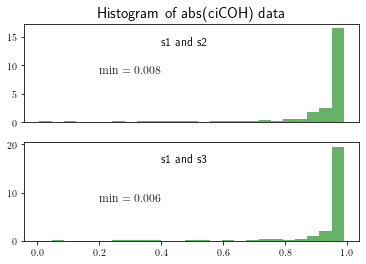

In [58]:
from scipy.stats import norm
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.figure()



### ciCOHs_12

ciCOHs = ciCOHs_sin12
ciCOHs = abs(np.array(ciCOHs))

# Fit a normal distribution to the data:
mu, std = norm.fit(abs(ciCOHs))

# Plot the histogram 
plt.subplot(211)
plt.hist(ciCOHs, bins=25, density=True, alpha=0.6, color='g')

eq1 = r"\begin{eqnarray*}" + \
      r"\min = " + str(np.around(np.min(ciCOHs), decimals=3)) + \
      r"\end{eqnarray*}"

plt.text(0.2, 10, eq1, {'fontsize': 12}, va="top", ha="left")
plt.text(0.4, 15, r"s1 and s2", {'fontsize': 12}, va="top", size=12, weight="bold")
plt.xticks([])


title = "Histogram of abs(ciCOH) data"
plt.title(title, size=15)

del ciCOHs



### ciCOHs_13

ciCOHs = ciCOHs_sin13
ciCOHs = abs(np.array(ciCOHs))

# Fit a normal distribution to the data:
mu, std = norm.fit(abs(ciCOHs))

plt.subplot(212)
plt.hist(ciCOHs, bins=25, density=True, alpha=0.6, color='g')


eq1 = r"\begin{eqnarray*}" + \
      r"\min = " + str(np.around(np.min(ciCOHs), decimals=3)) + \
      r"\end{eqnarray*}"

plt.text(0.2, 10, eq1, {'fontsize': 12}, va="top", ha="left")
plt.text(0.4, 18, r"s1 and s3", {'fontsize': 12}, va="top", size=12, weight="bold")



#plt.show()
plt.savefig(os.path.join(savefolder,  "sin_ciCOHHist.png"))

del ciCOHs

## Volume Conduction

In [63]:
alpha = 0.5

In [67]:
### no connection ####

x_noConn, y_noConn = sigs1_normal, sigs2_normal
ciCOH_ori, ciCOH_new = [], []
for timei in range(x_noConn.shape[0]):

    x, y = x_noConn[timei, :, :], y_noConn[timei, :, :] 
    x_new, y_new = x + alpha * y,  y + alpha * x

    # calculate ciCOH
    ciCOH_ori = np.append(ciCOH_ori, np.mean(ciCoherence_acrosstrials(x, y)))
    ciCOH_new = np.append(ciCOH_new, np.mean(ciCoherence_acrosstrials(x_new, y_new)))

    del x,  y, x_new, y_new
    
ciCOH_noConn_ori, ciCOH_noConn_new = ciCOH_ori, ciCOH_new
del ciCOH_ori, ciCOH_new

In [68]:
### connection ####

x_Conn, y_Conn = sigs1_sin, sigs2_sin
ciCOH_ori, ciCOH_new = [], []
for timei in range(x_Conn.shape[0]):

    x, y = x_Conn[timei, :, :], y_Conn[timei, :, :] 
    x_new, y_new = x + alpha * y,  y + alpha * x

    # calculate ciCOH
    ciCOH_ori = np.append(ciCOH_ori, np.mean(ciCoherence_acrosstrials(x, y)))
    ciCOH_new = np.append(ciCOH_new, np.mean(ciCoherence_acrosstrials(x_new, y_new)))

    del x,  y, x_new, y_new
    
ciCOH_Conn_ori, ciCOH_Conn_new = ciCOH_ori, ciCOH_new
del ciCOH_ori, ciCOH_new

### plot

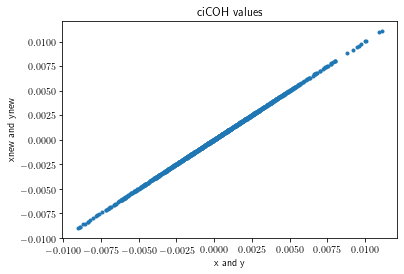

In [91]:
from scipy.stats import norm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(ciCOH_noConn_ori, ciCOH_noConn_new, '.')


ax.set(xlabel='x and y', ylabel='xnew and ynew',
       title='ciCOH values')

plt.savefig(os.path.join(savefolder,  "volume_noconn.png"))

In [86]:
ax

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.plot(ciCOH_Conn_ori, ciCOH_Conn_new, '.')
plt.xlabel('ciCOH values between two time series with no connections')
plt.ylabel('ciCOH values between two new generated time series')

plt.savefig(os.path.join(savefolder,  "volume_conn.png"))